In [1]:
# HIDDEN
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import pylab as pl
import math
from scipy import stats

In [2]:
# HIDDEN
baby = Table.read_table('baby.csv')

##Using the Bootstrap Method to Test Hypotheses
In the previous section we used the bootstrap method to estimate an unknown parameter. The bootstrap can also be used in statistical tests of hypotheses. 

For example, suppose we want to compare the mothers who smoke and the mothers who are non-smokers. Do they differ in any way other than smoking? A key variable of interest is the birth weight of their babies. To study this variable, we begin by noting that there are 715 non-smokers among the women in the sample, and 459 smokers.

In [3]:
baby.where(baby['m_smoker'],0).num_rows

715

In [103]:
baby.where(baby['m_smoker'],1).num_rows

459

The first histogram below displays the distribution of birth weights, in ounces, of the babies of the non-smokers in the sample. The second displays the birth weights of the babies of the smokers.

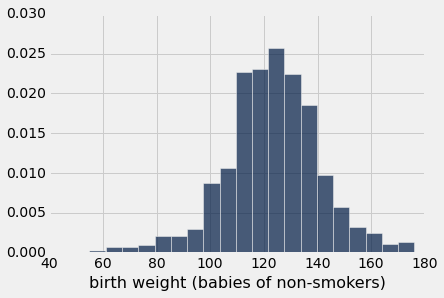

In [10]:
# birth weights of babies of non-smokers
baby.select('birthwt').where(baby['m_smoker'],0).hist(bins=20, normed=True)
plots.xlabel('birth weight (babies of non-smokers)')

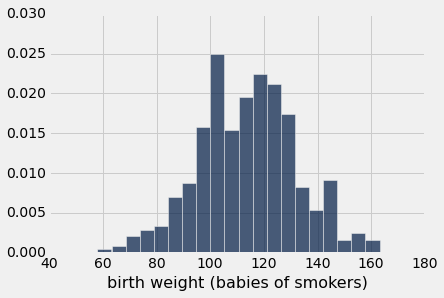

In [13]:
# birth weights of babies of smokers
baby.select('birthwt').where(baby['m_smoker'],1).hist(bins=20, normed=True)
plots.ylim(0, 0.03)
plots.xlabel('birth weight (babies of smokers)')

Both distributions are approximately bell shaped and centered near 120 ounces. The distributions are not identical, of course, which raises the question of whether the difference reflects just chance variation or a difference in the distributions in the population.

This question can be answered by a test of the null and alternative hypotheses below.

**Null hypothesis.** In the population, the distribution of birth weights of babies is the same for mothers who don't smoke as for mothers who do. The difference in the sample is due to chance.

**Alternative hypothesis.** The two distributions are different in the population.

Birth weight is a quantitative variable, so it is reasonable to start the analysis by using the difference in means as the test statistic.

The observed difference in the means of the two groups in the sample is about 9.27 ounces, as shown in the calculation below. It starts by extracting just the two columns needed for the test – the label of smoker or non-smoker, and the birth weight of the baby. It then computes the mean birth weight of the babies of the non-smokers and the mean of the babies of the smokers, and takes the difference of the two means.

In [19]:
sm_bwt = baby.select(['m_smoker','birthwt'])
nonsmokers_mean = np.mean(sm_bwt.where(sm_bwt['m_smoker'],0)['birthwt'])
smokers_mean = np.mean(sm_bwt.where(sm_bwt['m_smoker'],1)['birthwt'])
nonsmokers_mean - smokers_mean

9.2661425720249184

###Method 1: Permutation Test

To see whether such a difference could have arisen due to chance under the null hypothesis, we could use a permutation test just as we did in Chapter 3. Let us perform that test first, and then see how the bootstrap method compares with it.

The code below performs the permutation test based on 10,000 random permutations. Note that as before, no sample size is provided to the method ``sample``, because the default sample size is equal to the total number of rows in the table. The default sampling method of ``sample`` is to draw without replacement, which is exactly what is needed to create random permutations. This point will be important to recall when we switch to the bootstrap method.

Note also that the code starts by sorting the rows so that the rows corresponding to the 715 non-smokers appear first. This eliminates the need to use conditional expressions to identify the rows corresponding to smokers and non-smokers in each replication of the sampling process.

Observed difference in means:  9.26614257202


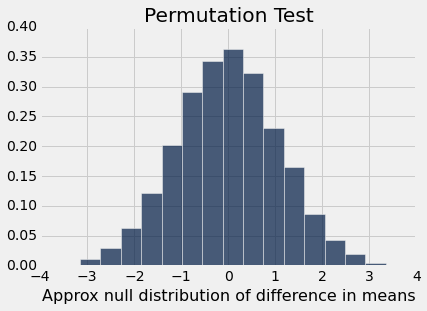

In [22]:
"""Permutation test for the difference in mean birthweight
Category A: non-smoker      Category B: smoker"""

bwt_sorted = baby.select(['m_smoker', 'birthwt']).sort('m_smoker')

# calculate the observed difference in means
meanA = np.mean(bwt_sorted['birthwt'][:715])
meanB = np.mean(bwt_sorted['birthwt'][715:])
obs_diff = meanA - meanB

repetitions=10000
diffs = []

for i in range(repetitions):
    
    # sample WITHOUT replacement, same number as original sample size
    resample = bwt_sorted.sample()
    
    # Compute the difference of the means of the resampled values, between Categories A and B
    dd = np.mean(resample['birthwt'][:715]) - np.mean(resample['birthwt'][715:])
    diffs.append([dd])

# Display results   
diffs = Table([diffs],['diff_in_means'])
diffs.hist(bins=20, normed=True)
plots.xlabel('Approx null distribution of difference in means')
plots.title('Permutation Test')
plots.xlim(-4, 4)
plots.ylim(0, 0.4)
print('Observed difference in means: ', obs_diff)

The figure test shows that under the null hypothesis of equal distributions in the population, the empirical distribution of the difference between the sample means of the two groups is roughly bell shaped, centered at 0, stretching from about $-4$ ounces to $4$ ounces. The observed difference in the original sample is about 9.27 ounces, which is inconsistent with this distribution. So the conclusion of the test is that in the population, the distributions of birth weights of the babies of non-smokers and smokers are different.

###Method 2: Bootstrap Test
The bootstrap test is identical to the permutation test in all but one respect: it samples *with* replacement instead of without. 

Compare the code for the bootstrap test below to see that it differs from the code for the permutation test only in that the option ``with_replacement=True`` has been used in the call to ``sample``, and the output has been labeled ``Bootstrap Test``.

Observed difference in means:  9.26614257202


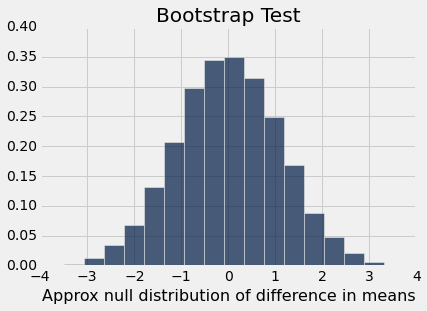

In [23]:
"""Bootstrap test for the difference in mean birthweight
Category A: non-smoker      Category B: smoker"""

bwt_sorted = baby.select(['m_smoker', 'birthwt']).sort('m_smoker')

# calculate the observed difference in means
meanA = np.mean(bwt_sorted['birthwt'][:715])
meanB = np.mean(bwt_sorted['birthwt'][715:])
obs_diff = meanA - meanB

repetitions=10000
diffs = []

for i in range(repetitions):
    
    # sample WITH replacement, same number as original sample size
    resample = bwt_sorted.sample(with_replacement=True)
    
    # Compute the difference of the means of the resampled values, between Categories A and B
    dd = np.mean(resample['birthwt'][:715]) - np.mean(resample['birthwt'][715:])
    diffs.append([dd])

# Display results   
diffs = Table([diffs],['diff_in_means'])
diffs.hist(bins=20, normed=True)
plots.xlabel('Approx null distribution of difference in means')
plots.title('Bootstrap Test')
plots.xlim(-4, 4)
plots.ylim(0, 0.4)
print('Observed difference in means: ', obs_diff)

Not surprisingly, the bootstrap empirical distribution of the difference in sample means under the null hypothesis is almost identical to that produced by random permutations, and the conclusion of the test is the same.

###Bootstrap A-B testing
As we have seen, bootstrap resampling methods can be used in the same way as random permutations to test the equality of two distributions, one from Category A and the other from Category B of a population. This is a version of what is rather unimanginatively known as *A-B testing*.

Let us define a function ``bootstrap_ab_test`` that performs A-B testing using the bootstrap method and the difference in sample means as the test statistic. The null hypothesis is that the two underlying distributions in the population are equal; the alternative is that they are not.

The arguments of the function are:

- the name of the table that contains the data in the original sample
- the label of the column containing the response variable (that is, the variable whose distribution is of interest)
- the label of the column containing the code 0 for Category A and 1 for Category B
- the number of repetitions of the resampling procedure

The function returns the observed difference in means, the bootstrap empirical distribution of the difference in means, and the bootstrap empirical $P$-value. Because the alternative simply says that the two underlying distributions are different, the $P$-value is computed as the proportion of sampled differences that are at least as large in absolute value as the absolute value of the observed difference.

In [51]:
"""Bootstrap A/B test for the difference in the mean response
Assumes A=0, B=1"""

def bootstrap_AB_test(samp_table, response_label, ab_label, repetitions):
    
    # Sort the sample table according to the A/B column; 
    # then select only the column of effects.
    response = samp_table.sort(ab_label).select(response_label)
    
    # Find the number of entries in Category A.
    n_A = samp_table.where(samp_table[ab_label],0).num_rows
      
    # Calculate the observed value of the test statistic.
    meanA = np.mean(response[response_label][:n_A])
    meanB = np.mean(response[response_label][n_A:])
    obs_diff = meanA - meanB
    
    # Run the bootstrap procedure and get a list of resampled differences in means
    diffs = []
    for i in range(repetitions):
        resample = response.sample(with_replacement=True)
        d = np.mean(resample[response_label][:n_A]) - np.mean(resample[response_label][n_A:])
        diffs.append([d])
    
    # Compute the bootstrap empirical P-value
    diff_array = np.array(diffs)
    p_value = np.count_nonzero(abs(diff_array) >= abs(obs_diff))/repetitions
    
    # Display results
    diffs = Table([diffs],['diff_in_means'])
    diffs.hist(bins=20,normed=True)
    plots.xlabel('Approx null distribution of difference in means')
    plots.title('Bootstrap A-B Test')
    print("Observed difference in means: ", obs_diff)
    print("Bootstrap empirical P-value: ", p_value)

We can now use the function ``bootstrap_AB_test`` to compare the smokers and non-smokers with respect to several different response variables. The tests show a significant difference between the two groups in birth weight (as shown earlier), gestational days, maternal age, and maternal pregnancy weight. It comes as no surprise that the two groups do not differ significantly in their mean heights.

Observed difference in means:  9.26614257202
Bootstrap empirical P-value:  0.0


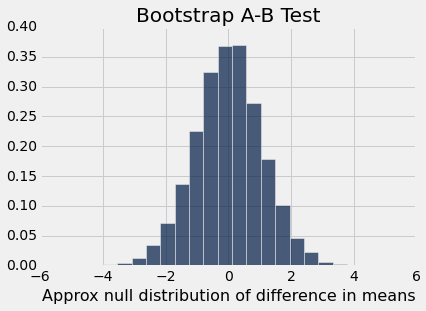

In [46]:
bootstrap_AB_test(baby, 'birthwt', 'm_smoker', 10000)

Observed difference in means:  1.97652238829
Bootstrap empirical P-value:  0.0376


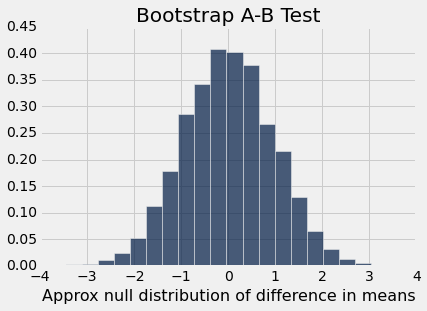

In [47]:
bootstrap_AB_test(baby, 'gest_days', 'm_smoker', 10000)

Observed difference in means:  0.80767250179
Bootstrap empirical P-value:  0.0203


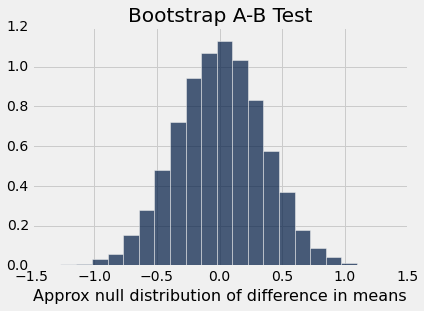

In [48]:
bootstrap_AB_test(baby, 'mat_age', 'm_smoker', 10000)

Observed difference in means:  2.56033030151
Bootstrap empirical P-value:  0.041


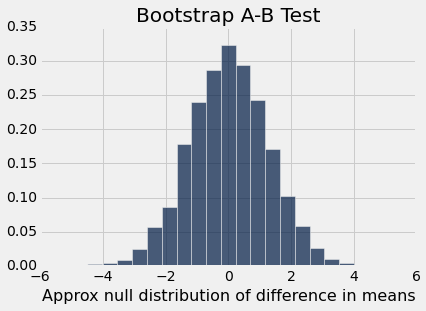

In [49]:
bootstrap_AB_test(baby, 'mat_pw', 'm_smoker', 10000)

Observed difference in means:  -0.0905891494127
Bootstrap empirical P-value:  0.5519


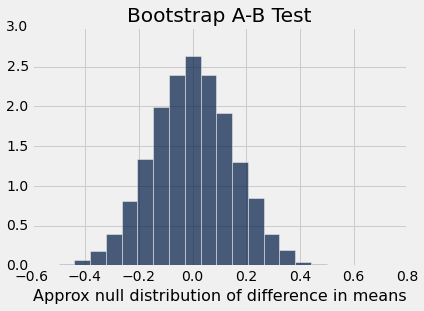

In [50]:
bootstrap_AB_test(baby, 'mat_ht', 'm_smoker', 10000)